In [31]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader,Dataset
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
from lib.utils import Windowset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['F1-0', 'B3-1', 'A4-0', 'F1-1', 'E2-1', 'C4-1', 'F5-1', 'E4-0', 'B1-0', 'A1-0', 'C1-0', 'E4-1'] ['A1-1', 'C4-0', 'D1-0', 'E1-0']
torch.Size([69120, 5000]) torch.Size([69120, 3])
tensor([ 3504, 31617, 33999])
Params:  90011


<All keys matched successfully>

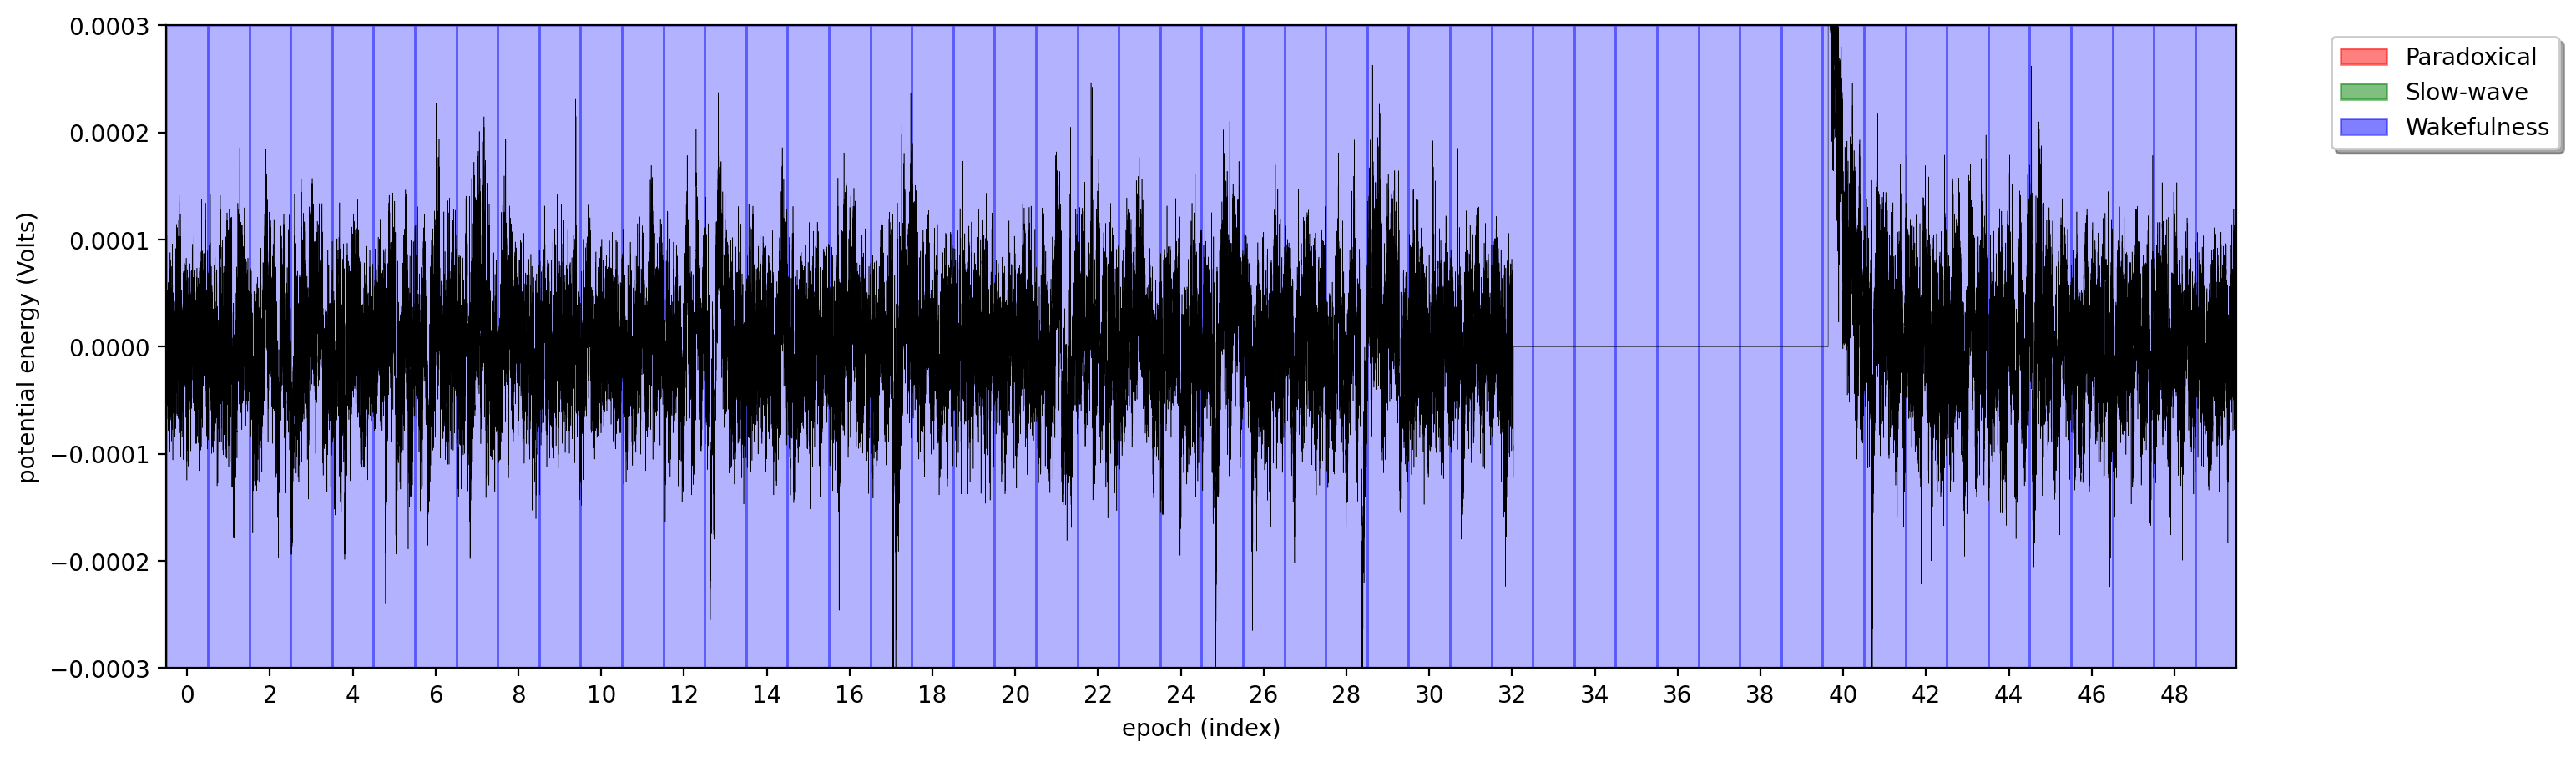

In [32]:
from torch.nn.functional import relu

windowsize = 1
idx = get_ekyn_ids()
train_idx,test_idx = train_test_split(idx,test_size=.25,random_state=0)
test_idx = test_idx
print(train_idx,test_idx)
X,y = load_eeg_label_pairs(ids=test_idx)
print(X.shape,y.shape)
print(bincount(y.argmax(axis=1)))
plot_eeg_and_labels(X,y.argmax(axis=1),start=0,duration=50)
devloader = DataLoader(Windowset(X,y,windowsize),batch_size=512,shuffle=False)

from lib.models import ResNetv2
model = ResNetv2(windowsize=windowsize)
criterion = nn.CrossEntropyLoss()
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

PROJECT_DIR = f'../projects/8'
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

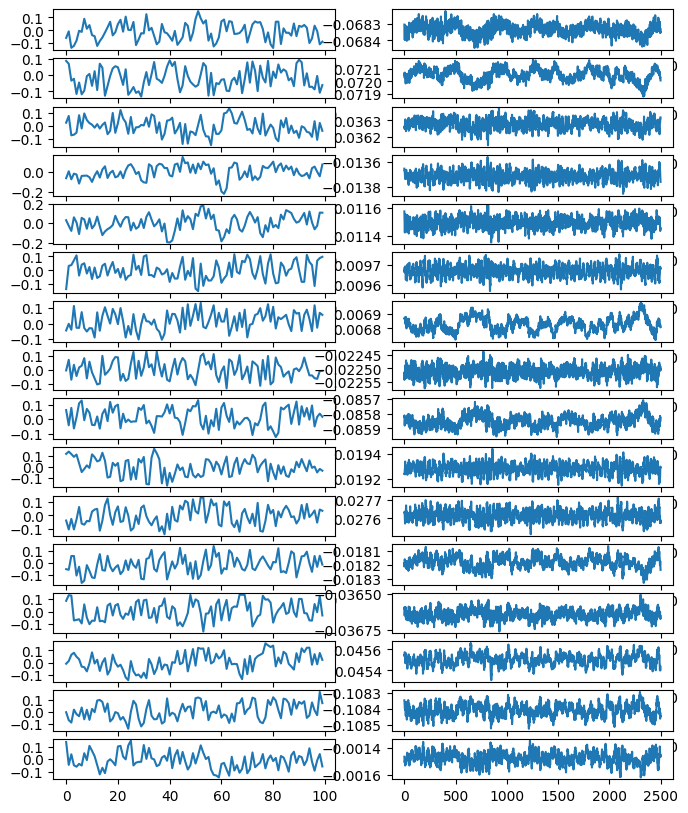

In [33]:
model.to('cpu')
Xi,yi = next(iter(devloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)

100%|██████████| 135/135 [00:04<00:00, 29.21it/s]


              precision    recall  f1-score   support

         0.0       0.71      0.64      0.67      3504
         1.0       0.95      0.91      0.93     31617
         2.0       0.89      0.93      0.91     33999

    accuracy                           0.91     69120
   macro avg       0.85      0.83      0.84     69120
weighted avg       0.91      0.91      0.91     69120

0.24624919218045693


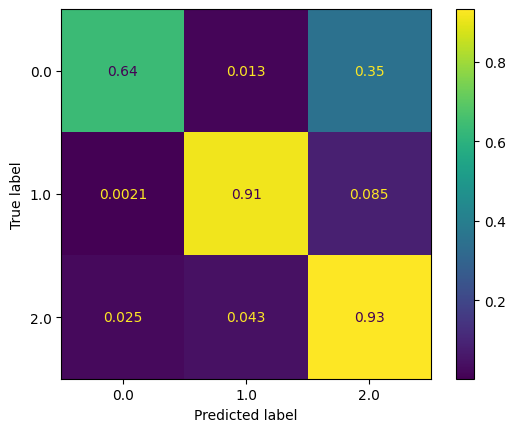

In [34]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)
# 0 : 75 f1
# 1 : 75 f1
# 4 : 81
# 6 : 82


[]

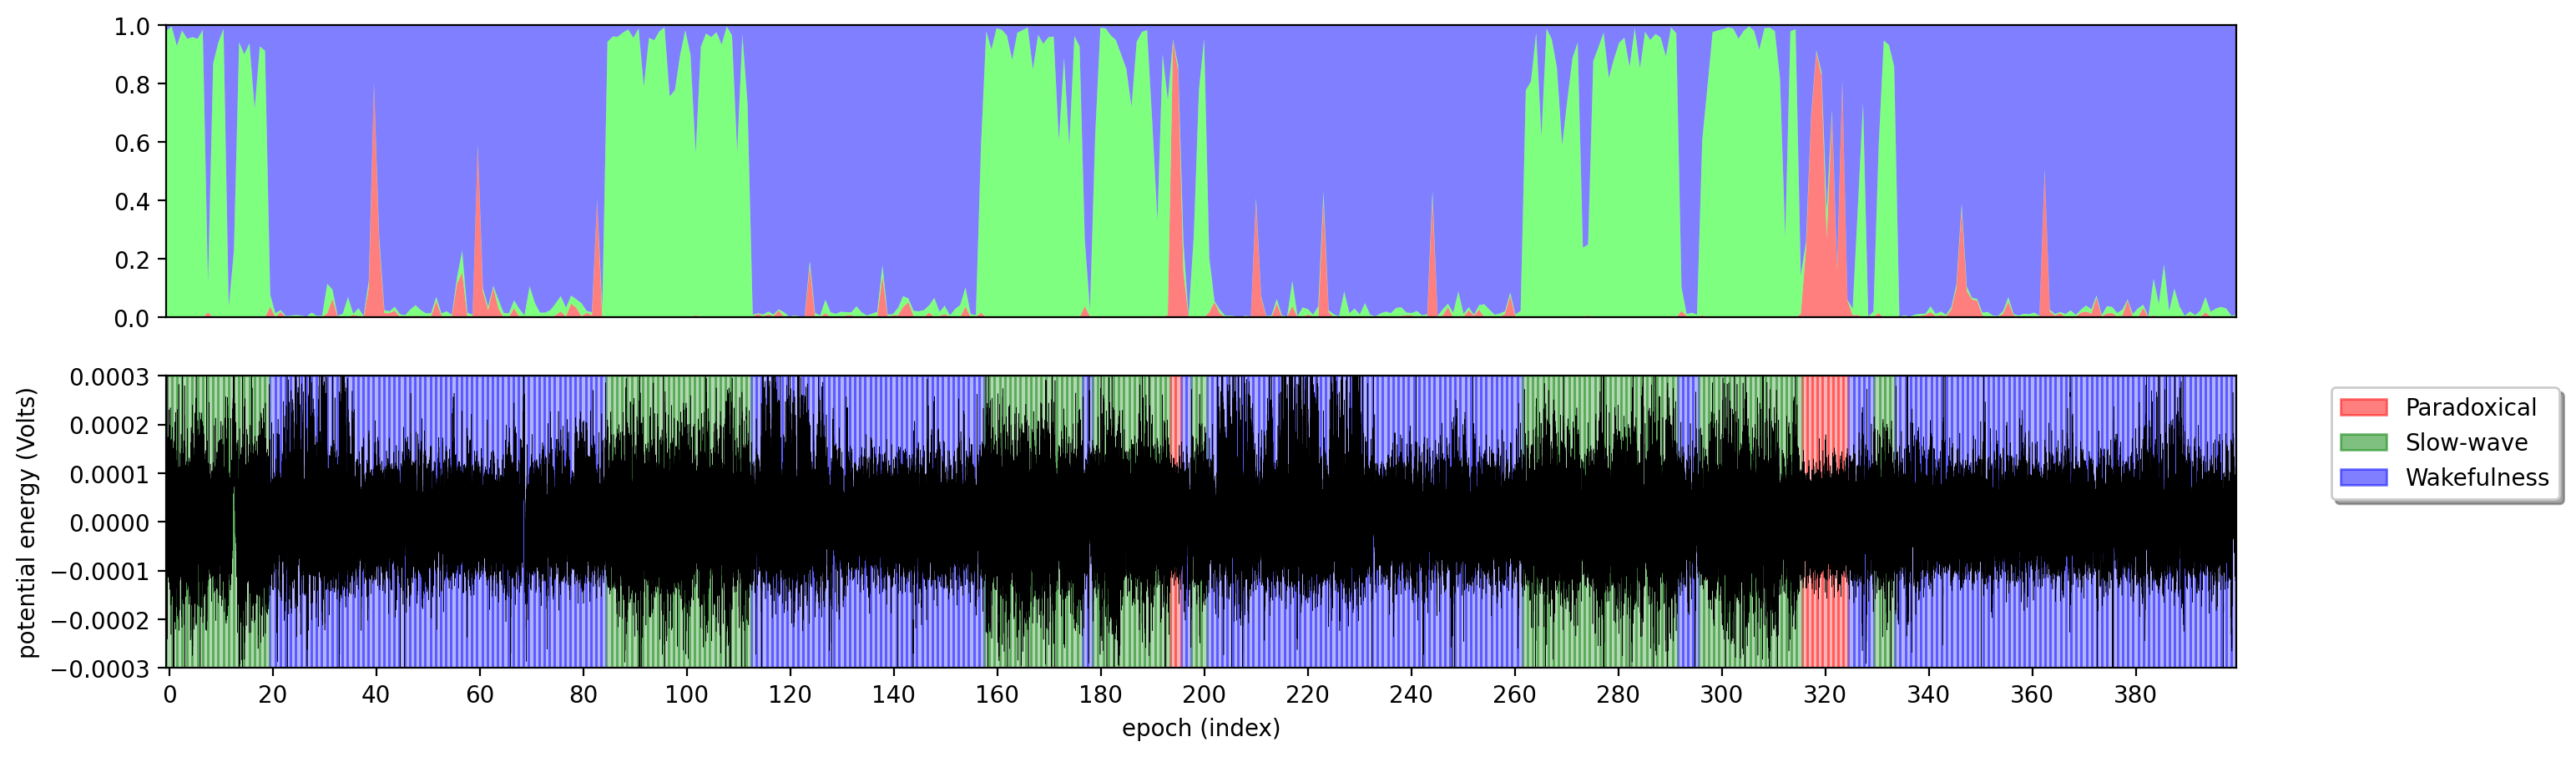

In [35]:
import matplotlib.patches as patches
start = 600
duration = 400
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,5),dpi=200)

ax[1].plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[1].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
ax[1].set_ylim([-.0003,.0003])
ax[1].margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
ax[1].set_ylabel('potential energy (Volts)')
ax[1].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

ax[0].stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
ax[0].margins(0,0)
ax[0].set_xticks([])